In [132]:
import opendatasets as od
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from catboost import CatBoostRegressor
from skopt.space import Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

import warnings

warnings.filterwarnings("ignore")

if not os.path.exists("../datasets"):
    os.makedirs("../datasets")

PROJECT_URL = "https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset"
PROJECT_NAME = PROJECT_URL.split("/")[-1]
DATA_PATH = os.path.join("../datasets", PROJECT_NAME)
od.download(PROJECT_URL, "../datasets")

Skipping, found downloaded files in "../datasets/usa-real-estate-dataset" (use force=True to force download)


#### Functions

In [133]:
# Removing outliers
def find_outliers(col):

    Q1, Q3 = col.describe()[["25%", "75%"]]
    IQR = Q3 - Q1
    high = Q3 + IQR * 1.5
    low = Q1 - IQR * 1.5
    is_outliar = col.map(lambda x: x > high or x < low)
    print(f"Found {(is_outliar).sum()} outliers")

    return is_outliar

def cv_calc(model, X, y, cv=5):
    
    t1 = time.time()
    scores = np.sqrt(-cross_val_score(model, X, y, cv=cv, n_jobs=-1, scoring="neg_mean_squared_error"))
    t2 = time.time() - t1
    calc_time = round(t2,2)
    scores = round(np.mean(scores),5)

    print(f"Cross validation Mean squared error: {scores}\nTime: {calc_time}s")

    return calc_time, scores

def custom_fillnas(df):
    df_imp = df.dropna(subset=["city", "state", "price"])

    # If the city has values
    df_imp.loc[:, "bed"] = df_imp["bed"].fillna(df_imp.groupby("city").bed.transform("median").transform("round"))
    df_imp.loc[:, "bath"] = df_imp["bath"].fillna(df_imp.groupby("city").bath.transform("median").transform("round"))
    df_imp.loc[:, "acre_lot"] = df_imp["acre_lot"].fillna(df_imp.groupby("city").acre_lot.transform("median"))
    df_imp.loc[:, "house_size"] = df_imp["house_size"].fillna(df_imp.groupby("city").house_size.transform("median"))
    # If the city is missing values
    df_imp.loc[:, "bed"] = df_imp["bed"].fillna(round(df_imp.bed.median()))
    df_imp.loc[:, "bath"] = df_imp["bath"].fillna(round(df_imp.bath.median()))
    df_imp.loc[:, "acre_lot"] = df_imp["acre_lot"].fillna(df_imp.acre_lot.median())
    df_imp.loc[:, "house_size"] = df_imp["house_size"].fillna(df_imp.house_size.median())

    df_imp = df_imp.dropna()
    X_imp = df_imp.drop(columns=["price"])
    y_imp = df_imp["price"].copy()

    return X_imp, y_imp

### EDA

In [134]:
df = pd.read_csv(os.path.join(DATA_PATH, "realtor-data.csv"))
df.head()

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,NaN,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,NaN,65000.0


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          100000 non-null  object 
 1   bed             75050 non-null   float64
 2   bath            75112 non-null   float64
 3   acre_lot        85987 non-null   float64
 4   city            99948 non-null   object 
 5   state           100000 non-null  object 
 6   zip_code        99805 non-null   float64
 7   house_size      75082 non-null   float64
 8   prev_sold_date  28745 non-null   object 
 9   price           100000 non-null  float64
dtypes: float64(6), object(4)
memory usage: 7.6+ MB


In [136]:
df.describe()

,bed,bath,acre_lot,zip_code,house_size,price
count,75050.000000,75112.000000,85987.000000,99805.000000,7.508200e+04,1.000000e+05
mean,3.701013,2.494595,13.613473,2132.003467,2.180082e+03,4.383656e+05
std,2.091372,1.573324,840.143878,2455.654774,5.625349e+03,1.015773e+06
min,1.000000,1.000000,0.000000,601.000000,1.000000e+02,4.450000e+02
25%,3.000000,2.000000,0.190000,971.000000,1.200000e+03,1.250000e+05
50%,3.000000,2.000000,0.510000,1225.000000,1.728000e+03,2.650000e+05
75%,4.000000,3.000000,2.000000,1611.000000,2.582000e+03,4.749000e+05
max,86.000000,56.000000,100000.000000,99999.000000,1.450112e+06,6.000000e+07


In [137]:
df.describe(include='O').T

,count,unique,top,freq
status,100000,2,for_sale,99819
city,99948,525,San Juan,4788
state,100000,12,Massachusetts,52694
prev_sold_date,28745,3604,2019-10-01,83


In [138]:
df.isnull().sum()

status                0
bed               24950
bath              24888
acre_lot          14013
city                 52
state                 0
zip_code            195
house_size        24918
prev_sold_date    71255
price                 0
dtype: int64

In [139]:
# Status seems irrelevant , prev_sold_date 71% missing values
df.drop(columns=["status", "prev_sold_date", "zip_code"], inplace=True)

From the output of <b>.describe()</b> we see that we have outliars. I will remove them using the rule anything outside the interval <b>[Q1 - interquartile range * 1.5,  Q3 + interquartile range * 1.5]</b> is an outliar. Running this in an iterative manner for every column gives better performance compared to precalculating them for each column before removing the outliars.

In [140]:
print(df.shape)
for c in ["bed", "bath", "acre_lot", "house_size", "price"]:
    print(f"checking {c}")
    
    df = df.loc[~find_outliers(df[c]), :]
print(df.shape)

(100000, 7)
checking bed
Found 10589 outliers
checking bath
Found 2131 outliers
checking acre_lot
Found 11063 outliers
checking house_size
Found 2232 outliers
checking price
Found 3358 outliers
(70627, 7)


In [141]:
print(df.state.value_counts())

state
Massachusetts     36051
Puerto Rico       18325
Connecticut        9623
Virgin Islands     1824
Rhode Island       1766
New Hampshire      1532
Vermont             761
New York            700
South Carolina       24
Tennessee            16
Virginia              3
New Jersey            2
Name: count, dtype: int64


In [142]:
# Drop states with low sample size
print(df.shape)
df = df.loc[~df.state.isin(["South Carolina", "Tennessee", "Virginia", "New Jersey"]), :]
print(df.shape)

(70627, 7)
(70582, 7)


In [143]:
df.city.value_counts()

city
San Juan            2949
Worcester           2169
Springfield         2044
Bayamon             1591
Pittsfield          1552
                    ... 
Stanford               1
Malden On Hudson       1
Madison                1
Johnsonville           1
East Greenbush         1
Name: count, Length: 493, dtype: int64

In [144]:
# Drop cities with low sample size
tmp = df.city.value_counts().reset_index()
city_count_map = dict(zip(tmp["city"], tmp["count"]))
df = df.assign(city_count = lambda x: x["city"].map(city_count_map))

print(df.shape)
df = df.loc[df["city_count"] >= 90, :]
print(df.shape)
df.drop(columns=["city_count"], inplace=True)

(70582, 8)
(61202, 8)


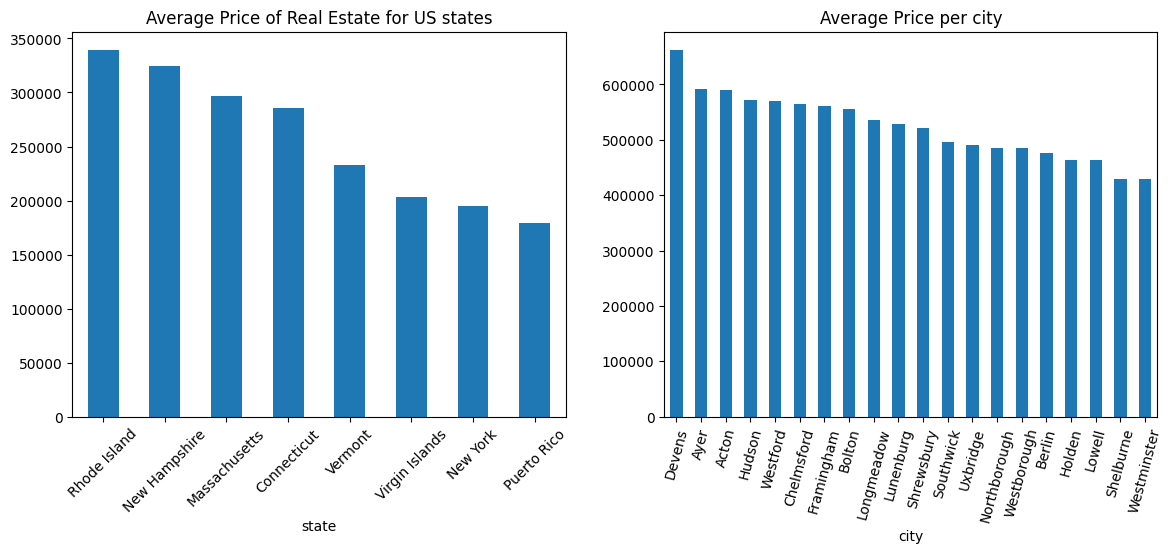

In [145]:
plt.figure(figsize=(14,5))
ax1 = plt.subplot(1,2,1)
df.groupby('state').price.mean().sort_values(ascending=False).plot.bar(ax=ax1)
plt.title('Average Price of Real Estate for US states')
plt.xticks(rotation=45)
ax2 = plt.subplot(1,2,2)
df.groupby('city').price.mean().sort_values(ascending=False).head(20).plot.bar(ax=ax2)
ax2.xaxis.set_tick_params(labelsize=10)
plt.title('Average Price per city')
plt.xticks(rotation=75)
plt.show()

#### Plots after cleaning

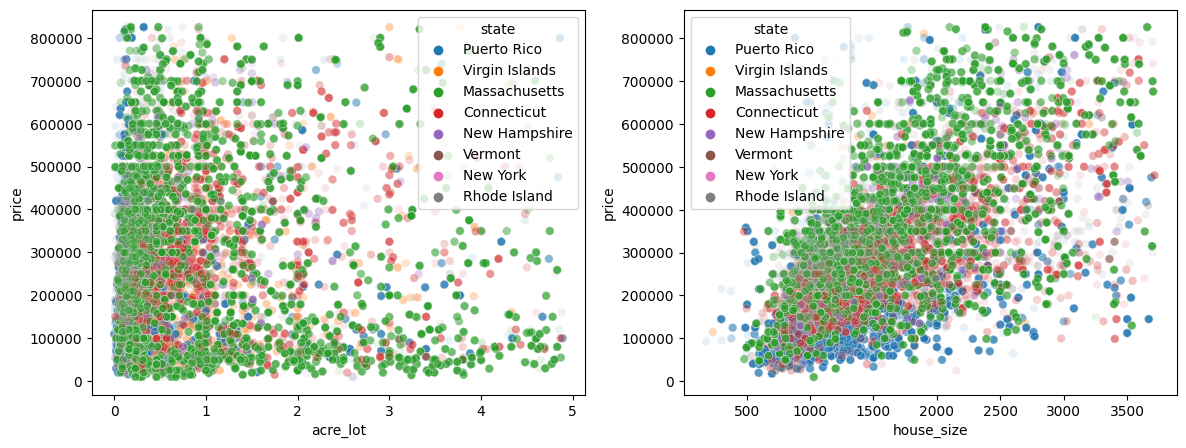

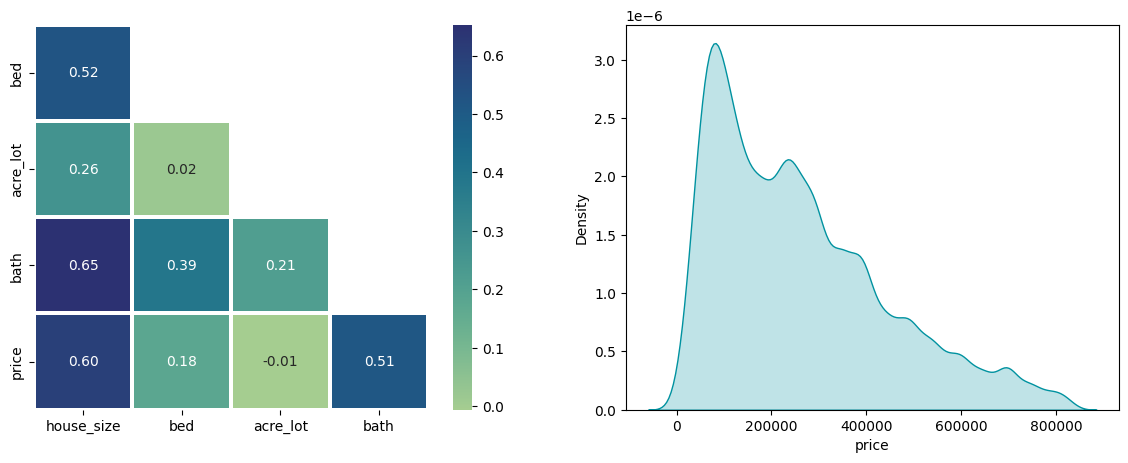

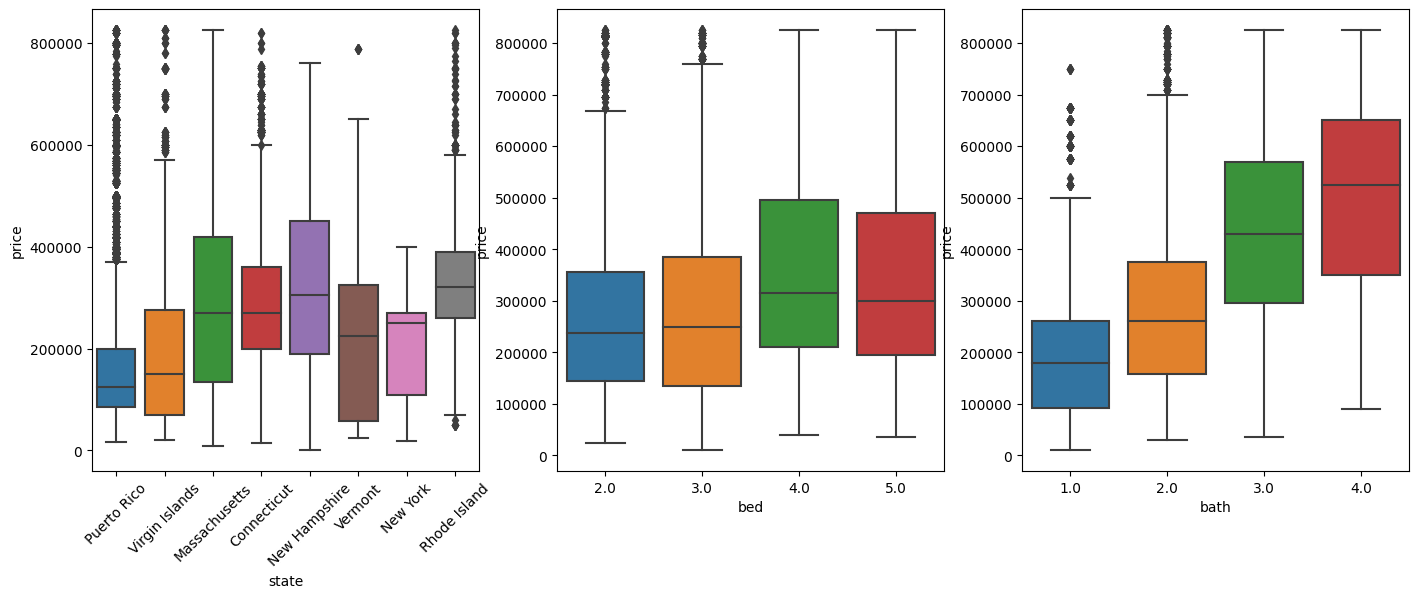

In [146]:
# Scatter plots
plt.figure(figsize=(14,5))
ax1 = plt.subplot(1,2,1)
sns.scatterplot(df, x="acre_lot", y="price", hue="state", alpha=0.1, ax=ax1)
ax2 = plt.subplot(1,2,2)
sns.scatterplot(df, x="house_size", y="price", hue="state", alpha=0.1, ax=ax2)
plt.show()

# Heat map with price distribution
plt.figure(figsize=(14,5))
corr_mat = df[["house_size", "bed", "acre_lot", "bath", "price"]].corr()
mask = np.triu(np.ones_like(corr_mat)).astype(bool)
mask = mask[1:, :-1]
corr_mat = corr_mat.iloc[1:,:-1]
ax1 = plt.subplot(1,2,1)
sns.heatmap(corr_mat, annot=True, linewidth=1.5, fmt=".2f", cmap="crest", mask=mask, ax=ax1)
ax2 = plt.subplot(1,2,2)
sns.kdeplot(df["price"], fill=True, color="#0092A0", ax=ax2)
plt.show()

# Box plots
plt.figure(figsize=(17,6))
ax1 = plt.subplot(1,3,1)
sns.boxplot(df, x="state", y="price", ax=ax1)
plt.xticks(rotation=45)
ax2 = plt.subplot(1,3,2)
sns.boxplot(df, x="bed", y="price", ax=ax2)
ax3 = plt.subplot(1,3,3)
sns.boxplot(df, x="bath", y="price", ax=ax3)
plt.show()

Looks like number of bathrooms and house size have a correlation with the price which is an expected result and should have strong predictive power.
Acre_lot - Price scatter plot doesn't reveal any obvious pattern. There is no obvious pattern for acre_lot. Also states are having different price distributions which is something I might be able to use.

## Models

In [147]:
metrics = {}


df_train, df_test = train_test_split(df, test_size=0.2, random_state=47, stratify=df["city"].tolist())

### Dropping all NaN values

In [148]:
# Drop rows that have at least one null value
print("Dataframe size before dropna:", df.shape)
df_train_dropna_all = df.dropna()
print("Dataframe size after dropna:", df_train_dropna_all.shape)

Dataframe size before dropna: (61202, 7)
Dataframe size after dropna: (37304, 7)


In [149]:
df_train_dropna_all.shape

(37304, 7)

In [150]:
# Split features and labels
X_dropna_all = df_train_dropna_all.drop(columns=["price"])
y_dropna_all = df_train_dropna_all["price"].copy()

<h5>Only with numerical columns</h5>

In [151]:
X_dropna_all_num = X_dropna_all.select_dtypes(exclude=["object"])

RandomForest

In [152]:
forest_reg = RandomForestRegressor(n_jobs=-1, random_state=47)
calc_time, score = cv_calc(forest_reg, X_dropna_all_num, y_dropna_all)
metrics["forest_dropna_num"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 47546.56714
Time: 1.79s


Ridge regression

In [153]:
# Ridge regression
l2_reg = Ridge(random_state=47)
calc_time, score = cv_calc(l2_reg, X_dropna_all_num, y_dropna_all)
metrics["ridge_dropna_num"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 137828.07293
Time: 0.48s


CatBoost

In [154]:
# Catboost
cat = CatBoostRegressor(random_state=47, verbose=0)
calc_time, score = cv_calc(cat, X_dropna_all_num, y_dropna_all)
metrics["catboost_dropna_num"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 98924.23563
Time: 8.09s


<h5>Adding categorical columns</h5>

RandomForest

In [155]:
X_dropna_all_oh = pd.get_dummies(X_dropna_all)

forest_reg = RandomForestRegressor(n_jobs=-1, random_state=47)
calc_time, score = cv_calc(forest_reg, X_dropna_all_oh, y_dropna_all)
metrics["forest_dropna_oh"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 35946.34327
Time: 8.95s


CatBoost

In [156]:
cat = CatBoostRegressor(random_state=47, verbose=0)
calc_time, score = cv_calc(cat, X_dropna_all_oh, y_dropna_all)
metrics["catboost_dropna_oh"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 61354.21051
Time: 10.16s


<h3> Fillnas </h3>

In [157]:
# fillnas
X_imp, y_imp = custom_fillnas(df_train)

<h5>Only numerical columns</h5>

Random forest

In [158]:
X_imp_num = X_imp.select_dtypes(exclude=["object"])

In [159]:
forest_reg = RandomForestRegressor(n_jobs=-1, random_state=47)
calc_time, score = cv_calc(forest_reg, X_imp_num, y_imp)
metrics["forest_fillna_num"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 39545.31049
Time: 1.64s


CatBoost

In [160]:
catboost_reg = CatBoostRegressor(verbose=0, random_state=47)
calc_time, score = cv_calc(catboost_reg, X_imp_num, y_imp)
metrics["catboost_fillna_num"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 97471.09706
Time: 8.5s


<h4>Fillnas one hot for categorical</h4>

In [161]:
X_imp_oh = pd.get_dummies(X_imp)

RandomForest

In [162]:
forest_reg = RandomForestRegressor(n_jobs=-1, random_state=47)
calc_time, score = cv_calc(forest_reg, X_imp_oh, y_imp)
metrics["forest_fillna_oh"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 30061.14568
Time: 25.95s


CatBoost

In [163]:
catboost_reg = CatBoostRegressor(verbose=0, random_state=47)
calc_time, score = cv_calc(catboost_reg, X_imp_oh, y_imp)
metrics["catboost_fillna_oh"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 73160.4381
Time: 12.59s


<b>Feature scaling</b>

In [164]:
scaler = StandardScaler()
X_imp_num = X_imp.select_dtypes(exclude=["object"])
X_imp_obj = X_imp.select_dtypes(exclude=["float64"])
X_temp = scaler.fit_transform(X_imp_num)
X_imp_num = pd.DataFrame(X_temp, columns=X_imp_num.columns.tolist())
X_imp_scaled = X_imp_num.join(X_imp_obj) 
X_imp_scaled_oh = pd.get_dummies(X_imp_scaled)

RandomForest

In [165]:
forest_reg = RandomForestRegressor(n_jobs=-1, random_state=47)
calc_time, score = cv_calc(forest_reg, X_imp_scaled_oh, y_imp)
metrics["forest_fillna_scaled"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 44311.81779
Time: 20.96s


CatBoost

In [166]:
catboost_reg = CatBoostRegressor(verbose=0, random_state=47)
calc_time, score = cv_calc(catboost_reg, X_imp_scaled_oh, y_imp)
metrics["catboost_fillna_scaled"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 103021.56626
Time: 11.9s


<h4>Feature Engineering</h4>

Adding clusters

In [167]:
def add_clusters(X, y):
    X_cp = X.copy()
    km = KMeans(n_clusters=4, random_state=47)
    tmp = X_cp.join(y).loc[: , ["bed", "bath", "house_size"]]
    tmp["cluster"] = km.fit_predict(tmp)
    tmp.loc[:, "cluster"] = tmp["cluster"].astype("category")
    X_cp["cluster"] = tmp["cluster"]

    return X_cp

In [168]:
X_imp_cls = add_clusters(X_imp, y_imp)
X_imp_cls_oh = pd.get_dummies(X_imp_cls)

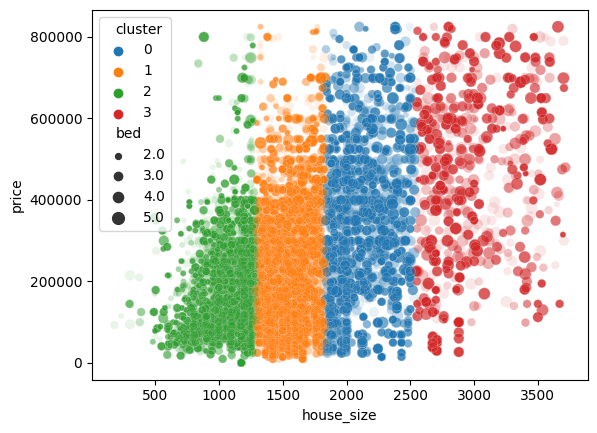

In [169]:
sns.scatterplot(x="house_size", y="price", hue="cluster", alpha=0.1, size="bed", data=X_imp_cls.join(y_imp))
plt.show()

In [170]:
forest = RandomForestRegressor(n_jobs=-1, random_state=47)
calc_time, score = cv_calc(forest, X_imp_cls_oh, y_imp)
metrics["forest_cluster_oh"] = {"time": calc_time, "score": score}

Cross validation Mean squared error: 30080.16577
Time: 26.9s


In [171]:
num_cols = list(X_imp.select_dtypes(exclude=["object"]))
cat_cols = list(X_imp.select_dtypes(exclude=["float64"]))

poly_transformer = ColumnTransformer([
    ("num", PolynomialFeatures(degree=2), num_cols),
    ("cat", OneHotEncoder(), cat_cols)
])

X_imp_augm_oh = poly_transformer.fit_transform(X_imp)

In [172]:
forest = RandomForestRegressor(n_jobs=-1, random_state=47)
calc_time, score = cv_calc(forest, X_imp_augm_oh, y_imp)
metrics["forest_polynom_oh"] = {"time": calc_time, "score": score}

Cross validation Mean squared error: 29896.27291
Time: 55.07s


In [173]:
pd.DataFrame(metrics).T.sort_values(by="score", ascending=True)

,time,score
forest_polynom_oh,55.07,29896.27291
forest_fillna_oh,25.95,30061.14568
forest_cluster_oh,26.90,30080.16577
forest_dropna_oh,8.95,35946.34327
forest_fillna_num,1.64,39545.31049
forest_fillna_scaled,20.96,44311.81779
forest_dropna_num,1.79,47546.56714
catboost_dropna_oh,10.16,61354.21051
catboost_fillna_oh,12.59,73160.43810
catboost_fillna_num,8.50,97471.09706


<b>Observations</b>
<ul>
    <li>Dropping outliars improved performance</li>
    <li>Dropping cities with low sample size improved performance and speed up training</li>
    <li>Adding clusters did not improve performance</li>
    <li>Feature engineering added some small performance gain (it is though in margin of error)</li>
    <li>Best performing model in all cases was the random forest</li>
</ul>

### Model optimization

In [174]:
# Running model optimization only on numerical columns without polynomial features to speed up process
search_space = [
    Integer(100, 1000, name="n_estimators"),
    Integer(5, 50, name="max_depth"),
    Integer(2, 100, name='min_samples_split'),
    Integer(1, 100, name='min_samples_leaf')
    ]

model = RandomForestRegressor(n_jobs=-1, random_state=47)

@use_named_args(search_space)
def evaluate_model(**params):
    model.set_params(**params)
    return  np.mean(np.sqrt(-cross_val_score(model, X_imp_oh, y_imp, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')))

# perform optimization
t1 = time.time()
forest_gp = gp_minimize(evaluate_model, search_space, n_calls=50, verbose=False, n_jobs=-1, random_state=47)
opt_time = time.time() - t1
# summarizing finding:
print("Total optimization time: %.2f  Best Accuracy: %.3f" % (opt_time, forest_gp.fun))
print(f"Best parameters: n_estimators={forest_gp.x[0]}, max_depth={forest_gp.x[1]}, min_samples_split={forest_gp.x[2]}, min_samples_leaf={forest_gp.x[3]}")

Total optimization time: 2271.69  Best Accuracy: 30903.340
Best parameters: n_estimators=100, max_depth=50, min_samples_split=2, min_samples_leaf=1


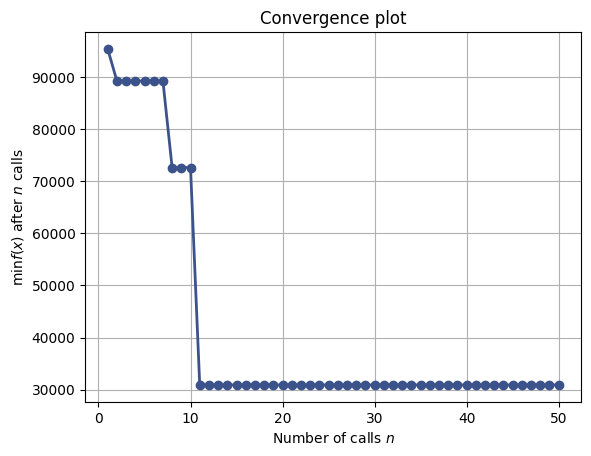

In [175]:
plot_convergence(forest_gp)
plt.show()

In [176]:
forest_opt = RandomForestRegressor(
    n_estimators=forest_gp.x[0], 
    max_depth=forest_gp.x[1], 
    min_samples_split=forest_gp.x[2], 
    min_samples_leaf=forest_gp.x[3],
    n_jobs=-1, random_state=47
    )

calc_time, score = cv_calc(forest_opt, X_imp_augm_oh, y_imp)
metrics["forest_opt_augm_oh"] = {"time": calc_time, "score": score}

Cross validation Mean squared error: 29961.04871
Time: 55.47s


In [177]:
forest_opt = RandomForestRegressor(
    n_estimators=forest_gp.x[0], 
    max_depth=forest_gp.x[1], 
    min_samples_split=forest_gp.x[2], 
    min_samples_leaf=forest_gp.x[3],
    n_jobs=-1, random_state=47
    )

calc_time, score = cv_calc(forest_opt, X_imp_oh, y_imp)
metrics["forest_opt_oh"] = {"time": calc_time, "score": score}

Cross validation Mean squared error: 30903.33993
Time: 26.1s


In [179]:
pd.DataFrame(metrics).T.sort_values(by="score", ascending=True)

,time,score
forest_polynom_oh,55.07,29896.27291
forest_opt_augm_oh,55.47,29961.04871
forest_fillna_oh,25.95,30061.14568
forest_cluster_oh,26.90,30080.16577
forest_opt_oh,26.10,30903.33993
forest_dropna_oh,8.95,35946.34327
forest_fillna_num,1.64,39545.31049
forest_fillna_scaled,20.96,44311.81779
forest_dropna_num,1.79,47546.56714
catboost_dropna_oh,10.16,61354.21051


Model optimization didn't find constrains on the model that produce better results

<h3>Model explainability</h3> (work in progress)

In [124]:
# work in progress
import eli5
from eli5.sklearn import PermutationImportance

X_test_imp, y_test_imp = custom_fillnas(df_test)
X_test_imp_oh = pd.get_dummies(X_test_imp)

final_model = RandomForestRegressor(n_jobs=-1, random_state=47).fit(X_imp_oh, y_imp)

perm = PermutationImportance(final_model, random_state=47).fit(X_test_imp_oh, y_test_imp)
eli5.show_weights(perm, feature_names=X_imp_oh.columns.tolist())


Weight,Feature
0.6878 ± 0.0072,house_size
0.3781 ± 0.0102,acre_lot
0.3288 ± 0.0103,bath
0.2625 ± 0.0094,state_Puerto Rico
0.1372 ± 0.0096,bed
0.0726 ± 0.0044,state_Massachusetts
0.0465 ± 0.0010,city_Belchertown
0.0368 ± 0.0017,state_Connecticut
0.0277 ± 0.0016,city_San Juan
0.0220 ± 0.0014,city_Carolina


In [125]:
from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(X_imp_oh, y_imp)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_imp_oh.columns)
mi_scores.sort_values(ascending=False)

house_size           4.020761
acre_lot             2.555561
bath                 0.340354
bed                  0.281781
state_Puerto Rico    0.252206
                       ...   
city_Cumberland      0.000000
city_Warwick         0.000000
city_Saint John      0.000000
city_Providence      0.000000
city_Middletown      0.000000
Name: MI Scores, Length: 201, dtype: float64